# VQE and QAOA with Qiskit

## Table of content
1. [Qiskit Optimization module](#optim)
 1. [The `QuadraticProgram` class](#qp)
 2. [From QP to QUBO to Operator](#qubo)
 3. [Optimization application class](#app)

2. [VQE and QAOA in Qiskit](#qiskit)
 1. [General overview](#gen)
 2. [Hamiltonian](#ham)
 3. [Optimizer](#opt)
 4. [Variational form or ansatz](#ansatz)
 5. [Quantum instance](#inst)
 6. [Minimum Eigen Optimizer](#meo)

3. [Application to the MaxCut problem](#maxcut)

4. [The runtime programs](#runtime)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import matplotlib.axes as axes
from numpy import cos, sin, pi

# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2, ExcitationPreserving, ZGate
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.visualization import plot_histogram

from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.opflow import Z

# Quantum and Classical algorithms
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, QAOA
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, NELDER_MEAD

# Optimization applications 
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.applications import optimization_application #sample_most_likely
from qiskit_optimization.algorithms import MinimumEigenOptimizer


# noise models and measurement mitigation
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

# set qiskit optimization logging
from qiskit_optimization import QiskitOptimizationError

## 1 - Qiskit optimization module <a name = 'optim'></a>

See [here](https://qiskit.org/documentation/optimization/tutorials/index.html) for all the optimization tutorials available in the documentation.

The code is open-source and available [here](https://github.com/Qiskit/qiskit-optimization).

    pip install qiskit-optimization

### A - The `QuadraticProgram` class <a name = 'qp'></a>

Here we'll see how to use the `QuadraticProgram` class to build an optimization problem using Qiskit.

It is possible to directly create a `QuadraticProgram` from a Docplex model via `from_docplex_mp` from `qiskit_optimization.translators` : 

    mod = from_docplex_mp(mdl)

You can also directly construct your program and give it the name you want. It supports three types of variables : binary, integer, continuous.

In [266]:
mod = QuadraticProgram('my problem')

In [267]:
mod.binary_var(name='x')
mod.integer_var(name='y', lowerbound=-1, upperbound=5)
mod.continuous_var(name='z', lowerbound=-1, upperbound=5)

In [268]:
mod.minimize(constant=3, linear={'x': 1}, quadratic={('x', 'y'): 2, ('z', 'z'): -1})

In [269]:
mod.minimize(constant=3, linear=[1,0,0], quadratic=[[0,1,0],[1,0,0],[0,0,-1]])

In [270]:
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: my problem

Minimize
 obj: x + [ 4 x*y - 2 z^2 ]/2 + 3
Subject To

Bounds
 0 <= x <= 1
 -1 <= y <= 5
 -1 <= z <= 5

Binaries
 x

Generals
 y
End



You can access the constant, the linear term, and the quadratic term by looking at `Quadratic.objective.{constant, linear, quadratic}`, respectively. As for linear and quadratic terms, you can get a dense matrix (`to_array`), a sparse matrix (`coefficients`), and a dictionary (`to_dict`). For dictionaries, you can specify whether to use variable indices or names as keys. Note that the quadratic terms are stored in a compressed way, e.g., `{('x', 'y'): 1, ('y', 'x'): 2}` is stored as `{('x', 'y'): 3}`. You can get the quadratic term as a symmetric matrix by calling `to_array(symmetric=True)` or `to_dict(symmetric=True)`. If you call `to_dict(name=True)`, you can get a dictionary whose keys are pairs of variable names.



In [271]:
print('constant:\t\t\t', mod.objective.constant)
print('linear dict:\t\t\t', mod.objective.linear.to_dict())
print('linear array:\t\t\t', mod.objective.linear.to_array())
print('linear array as sparse matrix:\n', mod.objective.linear.coefficients, '\n')
print('quadratic dict w/ index:\t', mod.objective.quadratic.to_dict())
print('quadratic dict w/ name:\t\t', mod.objective.quadratic.to_dict(use_name=True))
print('symmetric quadratic dict w/ name:\t', mod.objective.quadratic.to_dict(use_name=True, symmetric=True))
print('quadratic matrix:\n', mod.objective.quadratic.to_array(),'\n')
print('symmetric quadratic matrix:\n', mod.objective.quadratic.to_array(symmetric=True),'\n')
print('quadratic matrix as sparse matrix:\n', mod.objective.quadratic.coefficients)

constant:			 3
linear dict:			 {0: 1}
linear array:			 [1 0 0]
linear array as sparse matrix:
   (0, 0)	1 

quadratic dict w/ index:	 {(0, 1): 2, (2, 2): -1}
quadratic dict w/ name:		 {('x', 'y'): 2, ('z', 'z'): -1}
symmetric quadratic dict w/ name:	 {('y', 'x'): 1, ('x', 'y'): 1, ('z', 'z'): -1}
quadratic matrix:
 [[ 0  2  0]
 [ 0  0  0]
 [ 0  0 -1]] 

symmetric quadratic matrix:
 [[ 0  1  0]
 [ 1  0  0]
 [ 0  0 -1]] 

quadratic matrix as sparse matrix:
   (0, 1)	2
  (2, 2)	-1


You can also add linear and quadratic constraints by specifying the name, the linear and quadratic constraints, the sense, the RHS value. You can also access them plus its caracteristics easily.

In [272]:
mod.linear_constraint(linear={'x': 1, 'y': 2}, sense='==', rhs=3, name='lin_eq')
mod.linear_constraint(linear={'x': 1, 'y': 2}, sense='<=', rhs=3, name='lin_leq')
mod.linear_constraint(linear={'x': 1, 'y': 2}, sense='>=', rhs=3, name='lin_geq')

In [273]:
mod.quadratic_constraint(linear={'x': 1, 'y': 1}, quadratic={('x', 'x'): 1, ('y', 'z'): -1}, sense='==', rhs=1, name='quad_eq')
mod.quadratic_constraint(linear={'x': 1, 'y': 1}, quadratic={('x', 'x'): 1, ('y', 'z'): -1}, sense='<=', rhs=1, name='quad_leq')
mod.quadratic_constraint(linear={'x': 1, 'y': 1}, quadratic={('x', 'x'): 1, ('y', 'z'): -1}, sense='>=', rhs=1, name='quad_geq')

In [274]:
lin_geq = mod.get_linear_constraint('lin_geq')
print('lin_geq:', lin_geq.linear.to_dict(use_name=True), lin_geq.sense, lin_geq.rhs)
quad_geq = mod.get_quadratic_constraint('quad_geq')
print('quad_geq:', quad_geq.linear.to_dict(use_name=True), quad_geq.quadratic.to_dict(use_name=True), quad_geq.sense, lin_geq.rhs)


lin_geq: {'x': 1.0, 'y': 2.0} ConstraintSense.GE 3
quad_geq: {'x': 1.0, 'y': 1.0} {('x', 'x'): 1.0, ('y', 'z'): -1.0} ConstraintSense.GE 3


Finally, you can remove any constraint you have, and substitute any variable you want. An error will be return if the substitution is unfeasible or already done.

In [275]:
mod.remove_linear_constraint('lin_eq')
mod.remove_quadratic_constraint('quad_leq')
mod.remove_linear_constraint('lin_leq')
mod.remove_quadratic_constraint('quad_eq')


In [276]:
sub = mod.substitute_variables(constants={'x': 0}, variables={'y': ('z', -1)})


In [277]:
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: my problem

Minimize
 obj: x + [ 4 x*y - 2 z^2 ]/2 + 3
Subject To
 lin_geq: x + 2 y >= 3
 quad_geq: [ x^2 - y*z ] + x + y >= 1

Bounds
 0 <= x <= 1
 -1 <= y <= 5
 -1 <= z <= 5

Binaries
 x

Generals
 y
End



### B - From QP to QUBO to Operator <a name = 'qubo'></a>

Now, since Qiskit provides optimization algorithms that handle QUBO problems (Quadratic Unconstrained Binary Optimization) in particular, we need to be able to translate any quadratic problem into a QUBO. First let's construct a `QuadraticProgram` : 

In [232]:
qp = QuadraticProgram()
qp.binary_var('x')
qp.binary_var('y')
qp.integer_var(lowerbound=0, upperbound=4, name='z')

qp.maximize(linear={'x': 2, 'y': 1, 'z': 1})
qp.linear_constraint(linear={'x': 1, 'y': 1, 'z': 1}, sense='LE', rhs=3.5,name='xyz_leq')
qp.linear_constraint(linear={'x': 1, 'y': 1, 'z': 1}, sense='GE', rhs=2.5,name='xyz_geq')
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Maximize
 obj: 2 x + y + z
Subject To
 xyz_leq: x + y + z <= 3.500000000000
 xyz_geq: x + y + z >= 2.500000000000

Bounds
 0 <= x <= 1
 0 <= y <= 1
       z <= 4

Binaries
 x y

Generals
 z
End



`QuadraticProgramToQubo` is a wrapper for three (already available) converters in Qiskit : 
- `InequalityToEquality`: converts inequality constraints into equality constraints with additional slack variables. 
- `IntegerToBinary`: converts integer variables into binary variables and corresponding coefficients. 
- `LinearEqualityToPenalty`: convert equality constraints into additional terms of the object function.

All the details for each step is available [here](https://qiskit.org/documentation/optimization/tutorials/02_converters_for_quadratic_programs.html).

In [13]:
conv = QuadraticProgramToQubo()
qubo = conv.convert(qp)
print(qubo.export_as_lp_string())

The value could be too small. If so, set the penalty coefficient manually.


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 98 x - 97 y - 97 z@0 - 194 z@1 - 97 z@2 - 48 xyz_leq@int_slack@0
      - 96 xyz_leq@int_slack@1 + 48 xyz_geq@int_slack@0 + 96 xyz_geq@int_slack@1
      + [ 32 x^2 + 64 x*y + 64 x*z@0 + 128 x*z@1 + 64 x*z@2
      + 32 x*xyz_leq@int_slack@0 + 64 x*xyz_leq@int_slack@1
      - 32 x*xyz_geq@int_slack@0 - 64 x*xyz_geq@int_slack@1 + 32 y^2 + 64 y*z@0
      + 128 y*z@1 + 64 y*z@2 + 32 y*xyz_leq@int_slack@0
      + 64 y*xyz_leq@int_slack@1 - 32 y*xyz_geq@int_slack@0
      - 64 y*xyz_geq@int_slack@1 + 32 z@0^2 + 128 z@0*z@1 + 64 z@0*z@2
      + 32 z@0*xyz_leq@int_slack@0 + 64 z@0*xyz_leq@int_slack@1
      - 32 z@0*xyz_geq@int_slack@0 - 64 z@0*xyz_geq@int_slack@1 + 128 z@1^2
      + 128 z@1*z@2 + 64 z@1*xyz_leq@int_slack@0 + 128 z@1*xyz_leq@int_slack@1
      - 64 z@1*xyz_geq@int_slack@0 - 128 z@1*xyz_geq@int_slack@1 + 32 z@2^2
      + 32 z@2*xyz_leq@int_slack@0 + 64 z@2*xyz_leq@int_slack@1
     

Now in order to feed the VQE algorithm or the QAOA with the right type of data, we'll need an Ising hamiltonian. We'll see later how exactly the transformation is done. The code in Qiskit to go from QUBO to ising and vice versa.

In [14]:
ising, offset = qubo.to_ising()
print("The offset is : ", offset)
print("\nThe ising hamiltonian is : \n", ising)

The offset is :  84.5

The ising hamiltonian is : 
 -24.0 * ZIIIIIIII
- 12.0 * IZIIIIIII
+ 8.0 * ZZIIIIIII
- 24.0 * IIZIIIIII
- 12.0 * IIIZIIIII
+ 8.0 * IIZZIIIII
+ 0.5 * IIIIZIIII
- 8.0 * ZIIIZIIII
- 4.0 * IZIIZIIII
+ 8.0 * IIZIZIIII
+ 4.0 * IIIZZIIII
+ 1.0 * IIIIIZIII
- 16.0 * ZIIIIZIII
- 8.0 * IZIIIZIII
+ 16.0 * IIZIIZIII
+ 8.0 * IIIZIZIII
+ 16.0 * IIIIZZIII
+ 0.5 * IIIIIIZII
- 8.0 * ZIIIIIZII
- 4.0 * IZIIIIZII
+ 8.0 * IIZIIIZII
+ 4.0 * IIIZIIZII
+ 8.0 * IIIIZIZII
+ 16.0 * IIIIIZZII
+ 0.5 * IIIIIIIZI
- 8.0 * ZIIIIIIZI
- 4.0 * IZIIIIIZI
+ 8.0 * IIZIIIIZI
+ 4.0 * IIIZIIIZI
+ 8.0 * IIIIZIIZI
+ 16.0 * IIIIIZIZI
+ 8.0 * IIIIIIZZI
+ 1.0 * IIIIIIIIZ
- 8.0 * ZIIIIIIIZ
- 4.0 * IZIIIIIIZ
+ 8.0 * IIZIIIIIZ
+ 4.0 * IIIZIIIIZ
+ 8.0 * IIIIZIIIZ
+ 16.0 * IIIIIZIIZ
+ 8.0 * IIIIIIZIZ
+ 8.0 * IIIIIIIZZ


In [15]:
qubo = QuadraticProgram()
qubo.from_ising(qubit_op=ising, offset=offset, linear=True)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 82 x0 - 81 x1 - 81 x2 - 130 x3 - 81 x4 - 40 x5 - 64 x6 + 56 x7 + 128 x8
      + [ 64 x0*x1 + 64 x0*x2 + 128 x0*x3 + 64 x0*x4 + 32 x0*x5 + 64 x0*x6
      - 32 x0*x7 - 64 x0*x8 + 64 x1*x2 + 128 x1*x3 + 64 x1*x4 + 32 x1*x5
      + 64 x1*x6 - 32 x1*x7 - 64 x1*x8 + 128 x2*x3 + 64 x2*x4 + 32 x2*x5
      + 64 x2*x6 - 32 x2*x7 - 64 x2*x8 + 128 x3*x4 + 64 x3*x5 + 128 x3*x6
      - 64 x3*x7 - 128 x3*x8 + 32 x4*x5 + 64 x4*x6 - 32 x4*x7 - 64 x4*x8
      + 64 x5*x6 + 64 x7*x8 ]/2 + 144
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1
 0 <= x6 <= 1
 0 <= x7 <= 1
 0 <= x8 <= 1

Binaries
 x0 x1 x2 x3 x4 x5 x6 x7 x8
End



### C - Optimization application class <a name = 'app'></a>

Link to the documentation [here](https://qiskit.org/documentation/optimization/apidocs/qiskit_optimization.applications.html#module-qiskit_optimization.applications).

- Exact cover problem
>Given a collection of subsets of items, find a subcollection such that each item is covered exactly once.

- Knapsack problem
> Given a set of items, find a subset of items such that the total weight is within the capacity and the total value is maximized.

- Number partition problem
> Given a multiset of positive integers, find a partition of the multiset into two subsets such that the sums of the subsets are equal.

- Set packing problem
> Given a collection of subsets of items, find a subcollection such that all subsets of the subcollection are pairwise disjoint and the number of items in the subcollection is maximized.

*Graph problems*

- Clique problem
> Given an undirected graph, find a subset of nodes with a specified number or the maximum number such that the induced subgraph is complete.

- Graph partition problem
> Given an undirected graph, find a partition into two components whose sizes are equal such that the total capacity of the edges between the two components is minimized.

- Max-cut problem
> Given an undirected graph, find a partition of nodes into two subsets such that the total weight of the edges between the two subsets is maximized.

- Stable set problem
> Given an undirected graph, find a subset of nodes such that no edge connects the nodes in the subset and the number of nodes is maximized.

- Traveling salesman problem
> Given a graph, find a route with the minimum distance such that the route visits each city exactly once.

- Vehicle routing problem
> Given a graph, a depot node, and the number of vehicles (routes), find a set of routes such that each node is covered exactly once except the depot and the total distance of the routes is minimized.

- Vertex cover problem
> Given an undirected graph, find a subset of nodes with the minimum size such that each edge has at least one endpoint in the subsets.


The application classes for graph problems (GraphOptimizationApplication) provide a functionality to draw graphs of an instance and a result. Note that you need to install matplotlib beforehand to utilize the functionality.



## 2 - VQE and QAOA in Qiskit <a name = 'qiskit'></a>

### 2.1 - General overview <a name = 'gen'></a>

The **Variational Quantum Eigensolver algorithm** (VQE) and the **Quantum Approximate Optimization Algorithm** (QAOA) are both hybrid algorithms that use a variational technique to find the minimum eigenvalue of the *hamiltonian* $H$ of the studied system.

In both cases the algorithm is based on the variational method. It starts with a circuit called an **ansatz** or **trial state** parameterized by $\theta$. This parameter will vary thanks to a classical optimizer in order to minimize the energy value, and the final value found by the algorithm is an upper bound for the minimum energy. The associated ansatz will be a close approximation of the ground state.

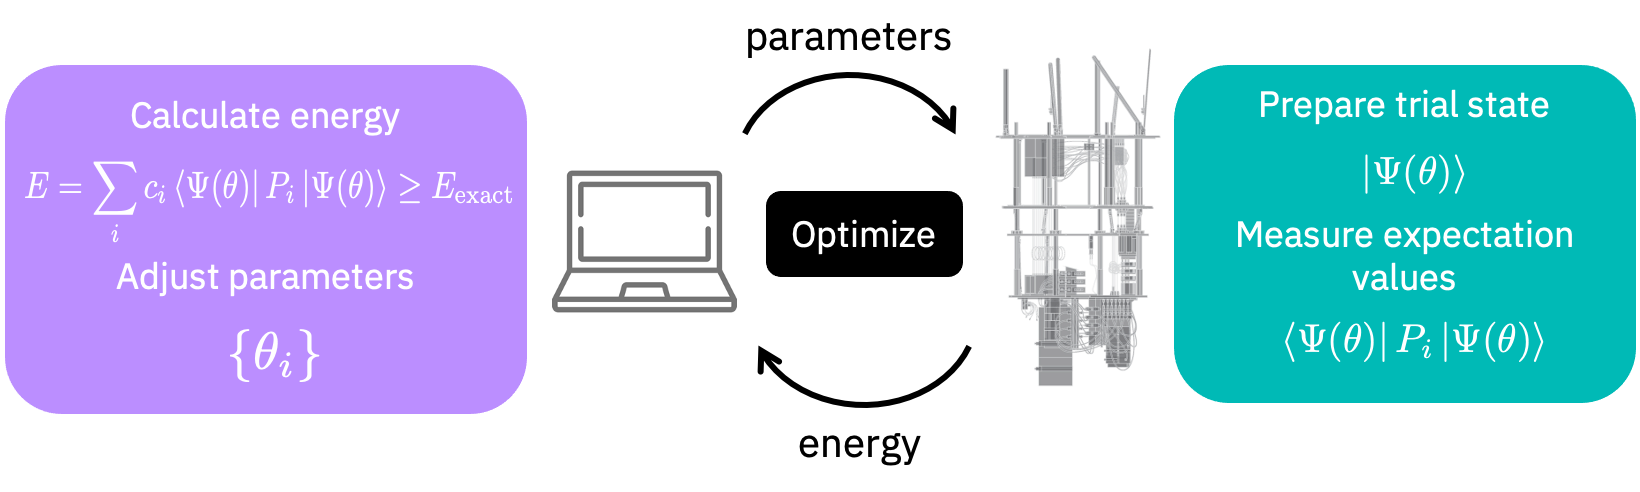

####  Comparison 
Both algorithms are variational quantum eigensolvers, meaning they use the **variational method** to approximate the ground state and the associated energy.  
QAOA is a special case of the VQE on the fact that it also relies on the **adiabatic theorem** : 
> If the hamiltonian of a quantum system in its ground state is perturbed slowly enough, the system varies in its ground state.

The ansatz of the QAOA consists of the preparation of the equal superposition state followed by $p$ repetitions of alterning cost and mixer layers.

See details of implementation here for the [VQE](https://qiskit.org/documentation/stubs/qiskit.algorithms.VQE.html#qiskit.algorithms.VQE) and here for the [QAOA](https://qiskit.org/documentation/stubs/qiskit.algorithms.QAOA.html?highlight=qaoa#qiskit.algorithms.QAOA).

### 2.2 - Optimizer  <a name = 'opt'></a>

The optimizer is on the classical part of the hybrid algorithm, and will send to the quantum circuit new parameters to be tested.

All the optimizers can be called from `qiskit.algorithms.optimizers`.   
See details [here](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html). The available optimizers on Qiskit are :

- **ADAM** : Adam Kingma, Diederik & Ba, Jimmy. (2014). Adam: A Method for Stochastic Optimization;
- **CG** : Conjugate Gradient algorithm;
- **COBYLA** : Constrained Optimization By Linear Approximation algorithm;
- **L_BFGS_B** : Limited-memory BFGS algorithm;
- **NELDER_MEAD** : Nelder-Mead algorithm;
- **P_BFGS** : Limited-memory BFGS algorithm. Parallel instantiations;
- **POWELL** : Powell algorithm;
- **SLSQP** : Sequential Least SQuares Programming algorithm;
- **SPSA** : Simultaneous Perturbation Stochastic Approximation algorithm;
- **TNC** : Truncated Newton algorithm;
- **AQGD** : Analytic Quantum Gradient Descent optimizer class. Performs optimization by gradient descent where gradients are evaluated “analytically” using the quantum circuit evaluating the objective function;
- **NFT** : Nakanishi-Fujii-Todo algorithm;
- **GSLS** : Gaussian-smoothed Line Search;
- **GradientDescend** : The gradient descent minimization routine;
- **QNSPSA** : The Quantum Natural SPSA (QN-SPSA) optimizer.

See this example for initializing an optimizer: 

In [16]:
from qiskit.algorithms.optimizers import COBYLA, SPSA

In [17]:
testOp = COBYLA(maxiter=500)
testOp

### 2.3 - Variational form or ansatz  <a name = 'ansatz'></a>

The **anzatz** (or **trial wavefunction**) is a mathematical guess as to what the answer may be. It prepares the state we need in order to apply the variational principle.


The ideal ansatz would be one that can reach as many states as possible while having a small depth. Of course, in practice, both are quite the opposite. The best balance is often hard to find and needs a little investigation beforehand. 

---

In Qiskit, there are three ways to create the ansatz for a VQE instance :  
- by using classes of parameterized circuits already implemented in Qiskit (the *N-Local circuits* in `qiskit.circuit.library`). See [here](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits) for all the details about each class.
- by creating a parameterized circuit. See [here](https://qiskit.org/documentation/tutorials/circuits_advanced/01_advanced_circuits.html) for how to create a parameterized circuit. Being able to use it for such algorithms is new in the latest version of Aqua, and is easier than before if one wants to create an ansatz.
- by doing both! Instances of the implemented classes are circuits, therefore any gate can be added to it.



#### An example - TwoLocal
The [two-local circuit](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html#qiskit.circuit.library.TwoLocal) is a ``parameterized`` circuit consisting of alternating rotation layers and
entanglement layers. The rotation layers are single qubit gates applied on all qubits.
The entanglement layer uses two-qubit gates to entangle the qubits according to a strategy set
using ``entanglement``.

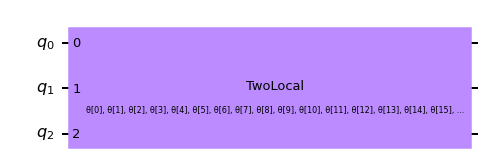

In [34]:
from qiskit.circuit.library import TwoLocal
rotation_blocks = ['ry', 'rz']
entanglement_blocks = ['cx']
testAnsatz = TwoLocal(num_qubits=3, 
                        rotation_blocks=rotation_blocks, 
                        entanglement_blocks=entanglement_blocks, 
                        entanglement='full',
                        reps=2,
                        skip_final_rotation_layer=False,
                        insert_barriers=True)
testAnsatz.draw(output='mpl')

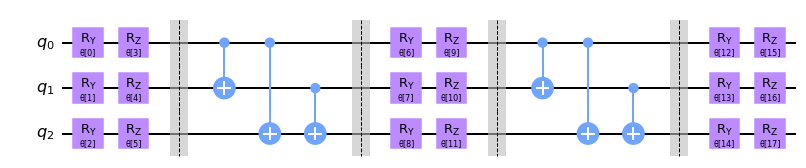

In [35]:
testAnsatz.decompose().draw(output='mpl')

**Example with a personalized circuit :** **(Parameterized circuits from Qiskit Core-Terra)**

In [36]:
n = 3

from qiskit.circuit import ParameterVector
theta = ParameterVector('θ', length=n)

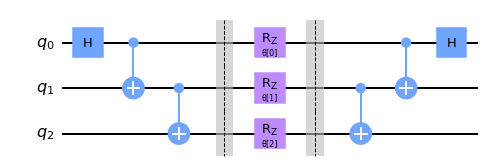

In [37]:
qc = QuantumCircuit(n)
qc.h(0)
for i in range(n-1):
    qc.cx(i,i+1)
qc.barrier()
for i in range(n):
    qc.rz(theta[i], i)
qc.barrier()
for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)
qc.draw('mpl')

### 2.4 - Hamiltonian  <a name = 'qubitop'></a>

The hamiltonian, describing the problem, is already implemented in Qiskit for several optimization problems. See [here](https://qiskit.org/documentation/optimization/apidocs/qiskit_optimization.applications.html) for all of the optimization problems already implemented.  
- For those already implemented, one can access the associated `QuadraticProgram` with the function `to_quadratic_program()`. 
- To access the ising hamiltonian and the offset, there is the method `QuadraticProgram.to_ising()`.



### 2.5 - Quantum instance  <a name = 'inst'></a>

A quantum instance allows to specify a backend and add configuration for the transpilation and the execution, such as the basis gates, the coupling map, backend options, noise model and many other options. See [here](https://qiskit.org/documentation/stubs/qiskit.utils.QuantumInstance.html#qiskit.utils.QuantumInstance) for more details.

### 2.6 - Minimum Eigen Optimizer  <a name = 'meo'></a>

For the use in Qiskit, VQE will require at least an ansatz and an optimizer, QAOA an optimizer and the $p$ value. Since both algorithms live at the core of Qiskit, the method to solve the considered system takes an Operator in an Ising form. To use those algorithms within Qiskit Optimization, there is an available wrapper that can take directly a `QuadraticProgram` in `qiskit_optimization.algorithms` : `MinimumEigenOptimizer`. 

- it translates from a `QuadraticProgram` to an Ising hamiltonian that will go into every available `MinimumEigenSolver`
- it takes care of  the call of the chosen `MinimumEigenSolver` in the computation
- it deals wih the raw results to translate them back to an `OptimizationResult` object.

Here is an example of how to use it : 

In [40]:
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Maximize
 obj: 2 x + y + z
Subject To
 xyz_leq: x + y + z <= 3.500000000000
 xyz_geq: x + y + z >= 2.500000000000

Bounds
 0 <= x <= 1
 0 <= y <= 1
       z <= 4

Binaries
 x y

Generals
 z
End



In [41]:
algorithm_globals.random_seed = 10598
quantum_instance = QuantumInstance(Aer.get_backend('statevector_simulator'),
                                   seed_simulator=algorithm_globals.random_seed,
                                   seed_transpiler=algorithm_globals.random_seed)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])

qaoa = MinimumEigenOptimizer(qaoa_mes)   # using QAOA

qaoa_result = qaoa.solve(qp)
print(qaoa_result)

The value could be too small. If so, set the penalty coefficient manually.


optimal function value: 4.0
optimal value: [1. 1. 1.]
status: SUCCESS


Remark : it is possible to compare the solution from the VQE and QAOA instance with the exact solution by using this function :   
    `from qiskit.algorithms import NumPyMinimumEigensolver`  
    `ee = NumPyMinimumEigensolver()`  
    `result = ee.compute_minimum_eigenvalue(qubitOp)`  

Or with the wrapper : 

In [42]:
exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

exact_result = exact.solve(qp)
print(exact_result)

The value could be too small. If so, set the penalty coefficient manually.


optimal function value: 4.0
optimal value: [1. 1. 1.]
status: SUCCESS


## 3 - Application to the MaxCut problem <a name = 'maxcut'></a>


Max-Cut is a well-known NP-complete optimization problem. Besides its theoretical importance, Max-Cut has applications in network science, clustering, and statistical physics.  

  
We formally define the Max-Cut problem as the following:  
We consider an undirected graph $G = (V,E)$ with $|V| = n$ nodes, and each edge $ij \in E$ has a weight $w_{i,j} = w_{j,i} >0$.

A **cut** of a graph is a partition of the set $V$ in two subset $A,B$ such that $A \sqcup B = V$.  
The objective of the optimization problem  is to maximize the total cost of all the edges connecting $A$ with $B$.



By assigning a binary variable $x_i$ to each node $i$, the cost function of the optimization problem is written this way:
$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j) = \sum_{(i,j) \in E} w_{ij} \left( x_i (1-x_j) + x_j (1-x_i)\right)$$



In order to be able to write the hamiltonian as a sum of Pauli operators, we will make the following transformation for each bit $x_i$:
$$ x_i \mapsto \frac{1}{2}\left(1-Z_i\right) $$
where $Z_i = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$ is the Pauli Z operator that acts only on qubit $i$ and leaves the rest unchanged.  
We can allow ourselves this mapping because first there is a bijective mapping between bits and spins; then considering $\pm 1$ are the eigenvalues of the Pauli Z operator, we can promote spins into operators.

Then, by applying the mapping from bits to Pauli Z operators we get the cost hamiltonian:
$$C \equiv H_C = \frac{1}{2} \sum_{(i,j) \in E} w_{ij}\left(  I - Z_iZ_j \right) $$

Maximizing the cost hamiltonian is equivalent to minimizing this quantity : $$ H = \sum_{(i,j) \in E} w_{ij}  Z_iZ_j $$

We'll consider an instance of a Maxcut problem. Let's consider the corresponding matrix of a 5 nodes graph:

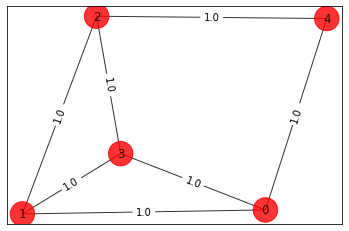

In [43]:
n=5   # we simulate 5 nodes 
G=nx.Graph() #Graph instance
G.add_nodes_from(np.arange(0,n,1)) #Set of nodes of the graph
#list of the edges of G with associated weight
e_list=[(0,1,1.0),(0,3,1.0),(0,4,1.0), (1,2,1.0),(1,3,1.), (2,3,1.0),(2,4,1.0)] 
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(e_list) #adding created edges to the graph

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [44]:
from sympy import Matrix
w = np.zeros([n,n])

for i in range(n):
    for j in range(i,n):
        edge = G.get_edge_data(i,j, default=0)
        if edge != 0:
            val = edge["weight"]
            w[i,j], w[j,i] = val, val
print ("This is our Hamiltonian: ")
Matrix(w)

This is our Hamiltonian: 


Matrix([
[  0, 1.0,   0, 1.0, 1.0],
[1.0,   0, 1.0, 1.0,   0],
[  0, 1.0,   0, 1.0, 1.0],
[1.0, 1.0, 1.0,   0,   0],
[1.0,   0, 1.0,   0,   0]])

It is possible to directly construct from the matrix the quadratic program via Qiskit. Next, getting the ising model is as easy.

In [234]:
# Call the method to convert the model into Ising Hamiltonian.
from qiskit_optimization.applications import Maxcut

max_cut = Maxcut(w)

qp = max_cut.to_quadratic_program()
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 3 x_0 + 3 x_1 + 3 x_2 + 3 x_3 + 2 x_4 + [ - 4 x_0*x_1 - 4 x_0*x_3
      - 4 x_0*x_4 - 4 x_1*x_2 - 4 x_1*x_3 - 4 x_2*x_3 - 4 x_2*x_4 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4
End



In [235]:
qubitOp, offset = qp.to_ising()
qubitOp, offset

print("The offset is : ", offset)
print("\nThe operator is : \n", qubitOp)

The offset is :  -3.5

The operator is : 
 0.5 * ZIZII
+ 0.5 * IZZII
+ 0.5 * IZIZI
+ 0.5 * IIZZI
+ 0.5 * ZIIIZ
+ 0.5 * IZIIZ
+ 0.5 * IIIZZ


You can also go from the Ising hamiltonian to the QUBO by doing this : 

In [236]:
testQUBO = QuadraticProgram()
testQUBO.from_ising(qubitOp, offset)
print(testQUBO.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: [ - 6 x0^2 + 4 x0*x1 + 4 x0*x3 + 4 x0*x4 - 6 x1^2 + 4 x1*x2 + 4 x1*x3
      - 6 x2^2 + 4 x2*x3 + 4 x2*x4 - 6 x3^2 - 4 x4^2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End



We execute VQE using the qasm_simulator.

In [49]:
seed = 10598
optimizer = COBYLA(maxiter=500, tol=0.0001)
# optimizer = SPSA(maxiter=300)
var_form = TwoLocal(qubitOp.num_qubits,'ry', 'cz',
                    reps=1,
                    insert_barriers=True, 
                    skip_final_rotation_layer=True, 
                    entanglement='linear')

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance)

vqe_result = vqe.compute_minimum_eigenvalue(qubitOp)

exact = NumPyMinimumEigensolver()
exact_run = exact.compute_minimum_eigenvalue(qubitOp)

print('\nVQE with the ansatz TwoLocal\n',vqe_result)
print('\nExact eigensolver\n',exact_run)


VQE with the ansatz TwoLocal
 {   'aux_operator_eigenvalues': None,
    'cost_function_evals': 75,
    'eigenstate': {'11010': 1.0},
    'eigenvalue': (-2.5+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[1]): -3.131051806612164,
                              ParameterVectorElement(θ[4]): -3.140097206029844,
                              ParameterVectorElement(θ[3]): 9.42060336365565,
                              ParameterVectorElement(θ[0]): -0.008894750440984492,
                              ParameterVectorElement(θ[2]): 0.003352480130327102},
    'optimal_point': array([-8.89475044e-03, -3.13105181e+00,  3.35248013e-03,  9.42060336e+00,
       -3.14009721e+00]),
    'optimal_value': -2.5,
    'optimizer_evals': None,
    'optimizer_time': 1.4258639812469482}

Exact eigensolver
 {   'aux_operator_eigenvalues': None,
    'eigenstate': VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0

energy: -2.5
time: 1.4258639812469482
max-cut objective: -6.0
solution: [0 1 0 1 1]
solution objective: 6.0


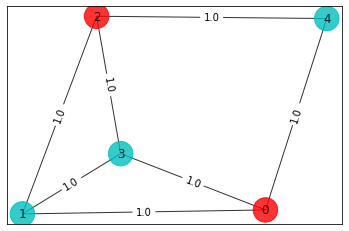

In [50]:
# print results
x = max_cut.sample_most_likely(vqe_result.eigenstate)
print('energy:', vqe_result.eigenvalue.real)
print('time:', vqe_result.optimizer_time)
print('max-cut objective:', vqe_result.eigenvalue.real + offset)
print('solution:', x)
print('solution objective:', qp.objective.evaluate(x))

# plot results
colors = ['r' if x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

**The same run with QAOA :**

In [93]:
seed = 10598
optimizer = COBYLA(maxiter=10000)
optimizer=SPSA(maxiter=1000)
p = 4

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
qaoa = QAOA(optimizer=optimizer,
            reps=p,
            quantum_instance=quantum_instance,
           initial_point=[0.,1.]*p)

qaoa_result = qaoa.compute_minimum_eigenvalue(qubitOp)


print('\nQAOA with p=2 \n',qaoa_result)
print('\nExact eigensolver\n',exact_run)


QAOA with p=2 
 {   'aux_operator_eigenvalues': None,
    'cost_function_evals': 2000,
    'eigenstate': {   '00000': 0.034938562148434216,
                      '00001': 0.048159484398195125,
                      '00010': 0.027063293868263706,
                      '00011': 0.03983608994994363,
                      '00100': 0.04133986423538423,
                      '00101': 0.6522384832731813,
                      '00110': 0.036643873123620545,
                      '00111': 0.15546678704790937,
                      '01000': 0.03314563036811941,
                      '01001': 0.04133986423538423,
                      '01010': 0.10597390598633231,
                      '01011': 0.011048543456039806,
                      '01100': 0.04555431167847891,
                      '01101': 0.1570293065800139,
                      '01110': 0.015625,
                      '01111': 0.03125,
                      '10000': 0.024705294220065465,
                      '10001': 0.015625,
      

energy: -2.269775390625
time: 44.97881293296814
max-cut objective: -5.769775390625
solution: [1 0 1 0 0]
solution objective: 6.0


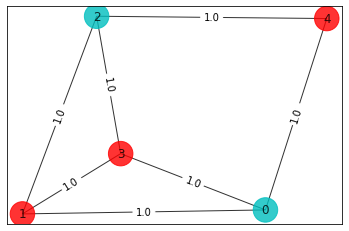

In [94]:
# print results
x = max_cut.sample_most_likely(qaoa_result.eigenstate)
print('energy:', qaoa_result.eigenvalue.real)
print('time:', qaoa_result.optimizer_time)
print('max-cut objective:', qaoa_result.eigenvalue.real + offset)
print('solution:', x)
print('solution objective:', qp.objective.evaluate(x))

# plot results
colors = ['r' if x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

**How to do it with the wrapper?**

In [237]:
exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

exact_result = exact.solve(qp)
print(exact_result)

optimal function value: 6.0
optimal value: [0. 1. 0. 1. 1.]
status: SUCCESS


In [238]:
qaoa_mes = MinimumEigenOptimizer(qaoa)  # using the exact classical numpy minimum eigen solver

qaoa_mes_result = qaoa_mes.solve(qp)
print(qaoa_mes_result)

optimal function value: 6.0
optimal value: [1. 0. 1. 0. 0.]
status: SUCCESS


In [241]:
vqe_mes = MinimumEigenOptimizer(vqe)  # using the exact classical numpy minimum eigen solver

vqe_mes_result = vqe_mes.solve(qp)
print(vqe_mes_result)

optimal function value: 6.0
optimal value: [0. 1. 0. 1. 1.]
status: SUCCESS


In [244]:
max_cut.interpret(vqe_mes_result)

[[0, 2], [1, 3, 4]]

In [246]:
max_cut.get_gset_result(vqe_mes_result.x)

{1: 1.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 0.0}

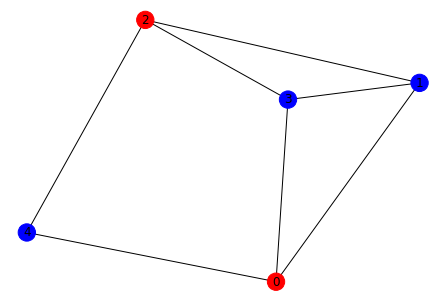

In [247]:
max_cut.draw(vqe_mes_result)

## 4 - The runtime programs <a name = 'runtime'></a>

The available programs are [here](https://quantum-computing.ibm.com/services?services=runtime).

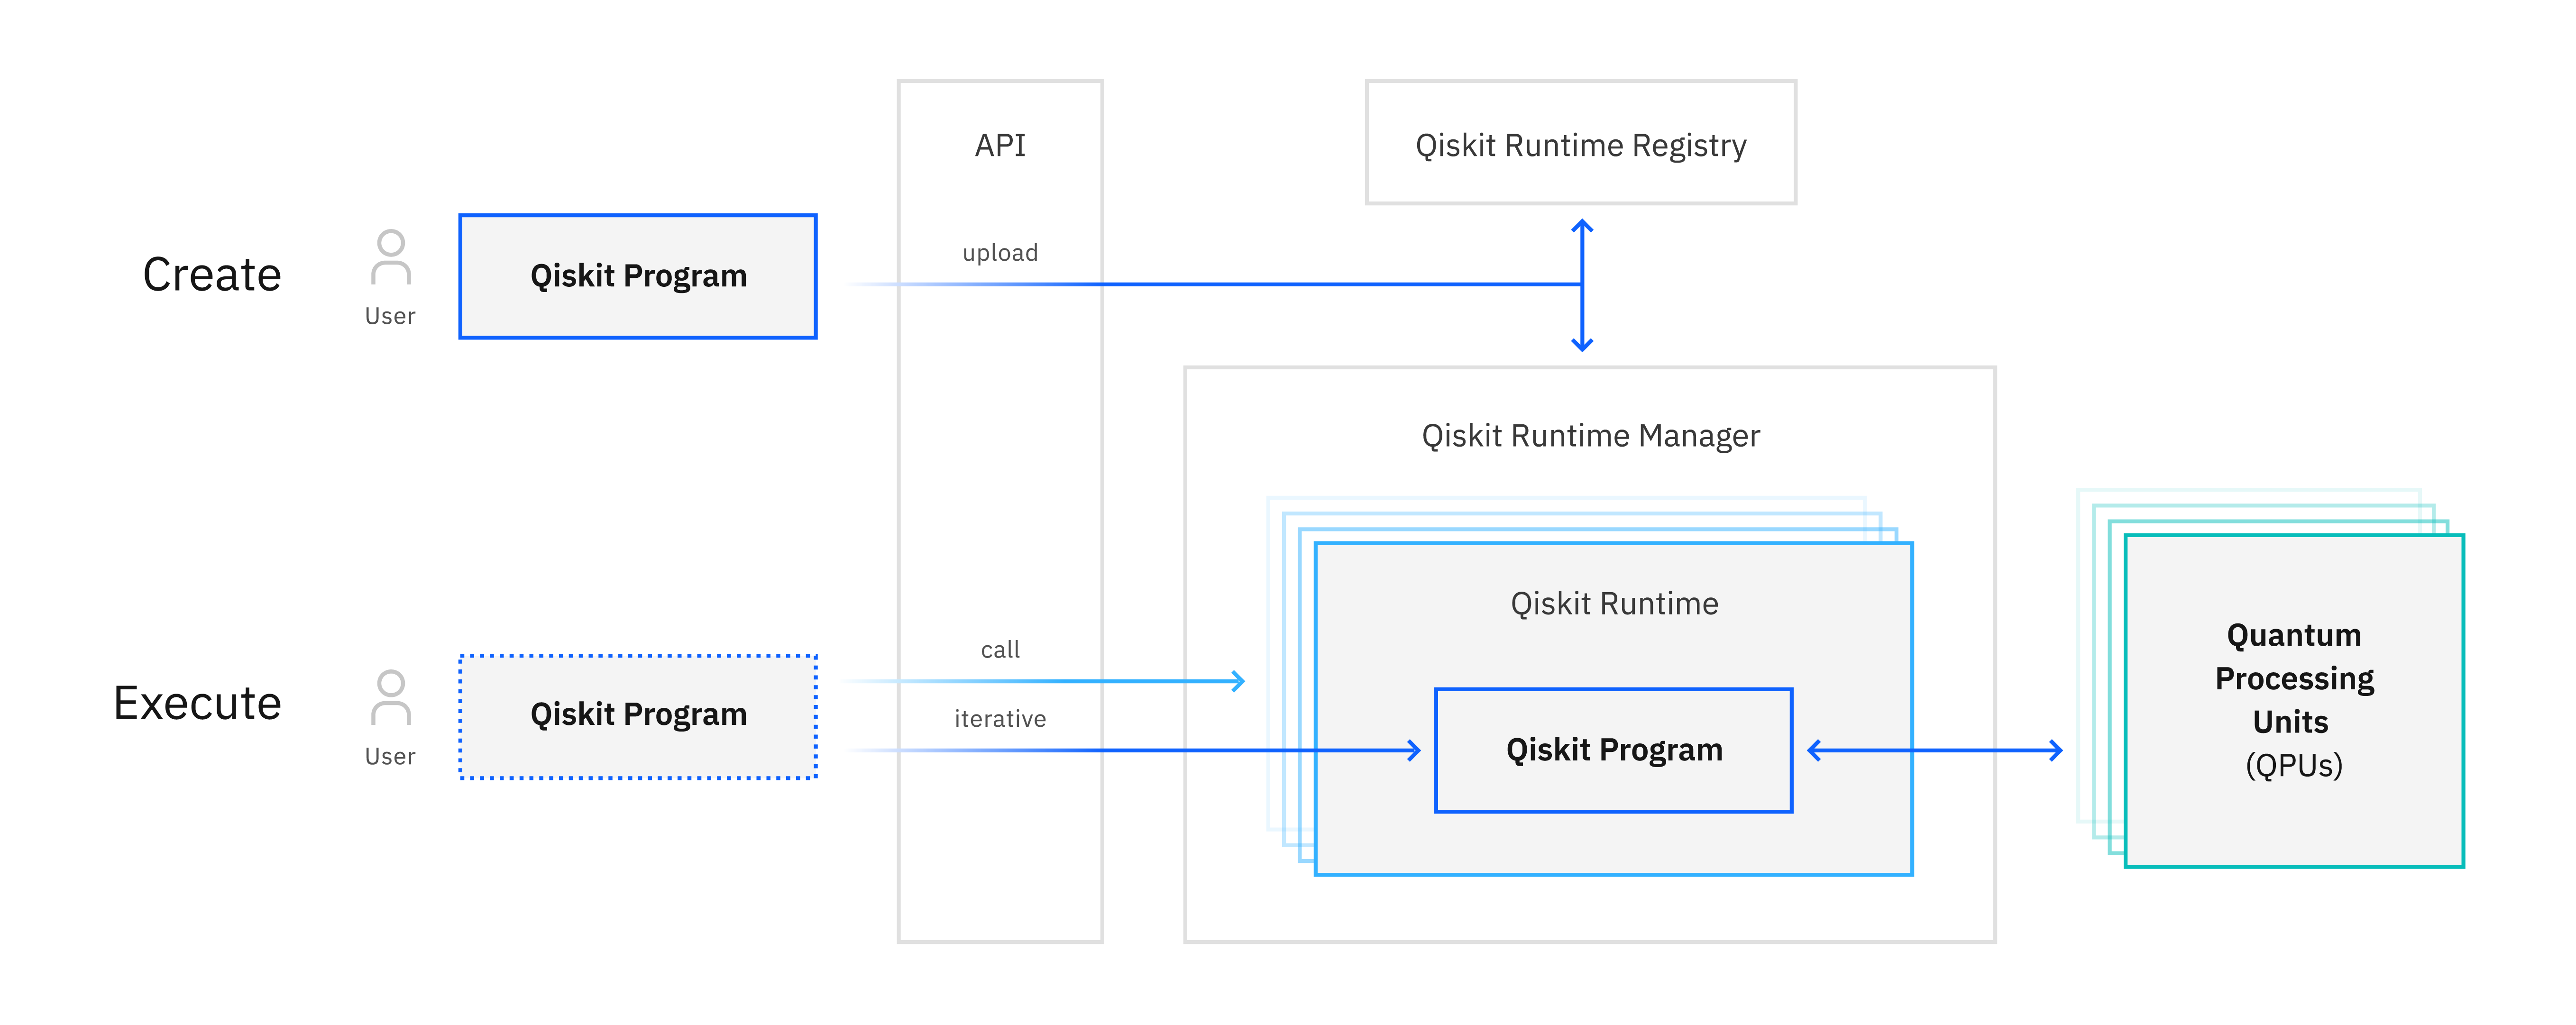

In [95]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub='your_hub', group='your_group', project='your_project')

In [ ]:
runtime_backends = provider.backends(input_allowed='runtime')
runtime_backends

In [96]:
simulator = provider.backend.ibmq_qasm_simulator
backend = provider.backend.ibmq_bogota

measurement_error_mitigation = False

In [97]:
def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

**VQE**

In [228]:
from qiskit_nature.runtime import VQEProgram

# in this first release, the optimizer must be specified as dictionary
optimizer = {'name': 'QN-SPSA',
             'maxiter': 500}

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}


initial_point = [0.]*var_form.num_parameters

runtime_vqe = VQEProgram(ansatz=var_form,
                         optimizer=optimizer,
                         initial_point=initial_point,
                         provider=provider,
                         backend=simulator,
                         shots=2048,
                         measurement_error_mitigation=measurement_error_mitigation,
                         callback=callback)

In [229]:
runtime_result = runtime_vqe.compute_minimum_eigenvalue(qubitOp)

In [230]:
print('Eigenvalue:', runtime_result.eigenvalue)

Eigenvalue: (-2.423828125+0j)


energy: -2.423828125
time: 75.79286599159241
max-cut objective: -5.923828125
solution: [0 1 0 1 1]
solution objective: 6.0


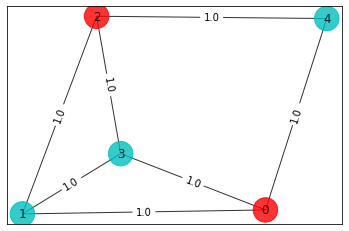

In [231]:
# print results
x = max_cut.sample_most_likely(runtime_result.eigenstate)
print('energy:', runtime_result.eigenvalue.real)
print('time:', runtime_result.optimizer_time)
print('max-cut objective:', runtime_result.eigenvalue.real + offset)
print('solution:', x)
print('solution objective:', qp.objective.evaluate(x))

# plot results
colors = ['r' if x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

In [279]:
intermediate_info['parameters']

[array([ 0.1,  0.1, -0.1,  0.1,  0.1]),
 array([-0.1, -0.1,  0.1, -0.1, -0.1]),
 array([ 0.5828375,  0.5828375, -0.5828375,  0.5828375,  0.5828375]),
 array([ 0.39636021,  0.39636021, -0.39636021,  0.39636021,  0.39636021]),
 array([ 31.59405202,  31.77304695, -31.77304695,  31.59405202,
         31.77304695]),
 array([ 31.77304695,  31.59405202, -31.59405202,  31.77304695,
         31.59405202]),
 array([ 29.55866663,  33.80843234, -33.80843234,  29.38479772,
         33.98230125]),
 array([ 29.38479772,  33.98230125, -33.98230125,  29.55866663,
         33.80843234]),
 array([ 34.60890876,  28.75819021, -28.92818437,  24.50454976,
         39.03254338]),
 array([ 34.4389146 ,  28.92818437, -28.75819021,  24.33455559,
         38.86254921]),
 array([ 33.94860836,  29.25159815, -28.26788397,  23.84424935,
         38.53913544]),
 array([ 34.11550082,  29.41849061, -28.43477643,  24.01114181,
         38.37224297]),
 array([ 46.93532956,  42.40263356, -41.41891937,  36.99528475,
       

**QAOA**

In [210]:
from qiskit_optimization.runtime import QAOAProgram

# in this first release, the optimizer must be specified as dictionary
optimizer = {'name': 'SPSA',
             'maxiter': 500}

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

p=5

initial_point = [0., 1.]*(p)

runtime_qaoa = QAOAProgram(optimizer=optimizer,
                            reps=p,
                            initial_point=initial_point,
                            provider=provider,
                            backend=simulator,
                            shots=8192,
                            measurement_error_mitigation=measurement_error_mitigation,
                            callback=callback)

In [211]:
runtime_result_qaoa = runtime_qaoa.compute_minimum_eigenvalue(qubitOp)

In [212]:
print('Eigenvalue:', runtime_result_qaoa.eigenvalue)

Eigenvalue: (-2.2928466796875+0j)


energy: -2.2928466796875
time: 100.63065910339355
max-cut objective: -5.7928466796875
solution: [0 1 0 1 1]
solution objective: 6.0


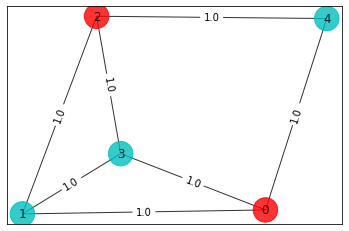

In [215]:
# print results
x = max_cut.sample_most_likely(runtime_result_qaoa.eigenstate)
print('energy:', runtime_result_qaoa.eigenvalue.real)
print('time:', runtime_result_qaoa.optimizer_time)
print('max-cut objective:', runtime_result_qaoa.eigenvalue.real + offset)
print('solution:', x)
print('solution objective:', qp.objective.evaluate(x))

# plot results
colors = ['r' if x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)